In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties_naive.csv"
data_pd = pd.read_csv(data_file)

In [2]:
data_pd.head(20)

,Unnamed: 0,patient_id,laterality,first_injection_date,Naive,sequence,Unnamed: 0.1,study_date_1,total_fluid_1,time_range_1,...,next_va_24,intra_retinal_fluid_24,sub_retinal_fluid_24,srhm_24,fibrovascular_ped_24,choroid_24,drusen_24,rpe_24,epiretinal_membrane_24,fibrosis_24
0,0,18,R,2017-09-26,1,18_R,0.0,2017-10-24,0.001141,NaN,...,NaN,0.002282,0.000074,0.007628,0.021696,2.288639,0.103669,0.442962,0.000166,0.000000
1,1,502,L,2017-07-04,1,502_L,1.0,2017-07-04,0.002359,NaN,...,NaN,0.004142,0.058838,0.011731,0.655212,0.781128,0.018328,0.483630,0.004739,0.013973
2,2,709,L,2016-08-08,1,709_L,4.0,2016-08-08,0.270185,NaN,...,0.886057,0.038588,0.001382,0.064977,0.193780,1.385576,0.000991,0.347591,0.080791,0.494781
3,3,1263,L,2015-07-31,1,1263_L,6.0,2016-02-29,0.002058,NaN,...,0.397940,0.000174,0.000054,0.005304,0.085024,2.119622,0.026682,0.494649,0.004095,0.010608
4,4,1263,R,2015-08-14,1,1263_R,7.0,2016-05-06,0.001133,NaN,...,0.397940,0.003474,0.000033,0.002744,0.072096,1.422588,0.035863,0.446715,0.002494,0.015225
5,5,1475,L,2016-04-07,1,1475_L,8.0,2016-04-07,0.047893,NaN,...,0.602060,0.026477,0.020254,0.007385,0.071712,0.672631,0.001486,0.438873,0.004323,0.148093
6,7,1557,R,2013-09-27,1,1557_R,11.0,2013-09-20,0.389026,NaN,...,0.698970,0.000693,0.001843,0.019360,0.240204,2.128582,0.008848,0.437410,0.008200,0.067541
7,8,1826,L,2016-06-02,1,1826_L,14.0,2016-08-08,0.119052,NaN,...,NaN,0.002285,0.002121,0.002930,0.334928,0.876528,0.004297,0.416064,0.013142,0.095830
8,9,2005,L,2016-06-17,1,2005_L,15.0,2016-09-09,0.094189,NaN,...,NaN,0.000810,0.024096,0.001138,0.405621,1.279548,0.011018,0.459778,0.068946,0.000799
9,10,2005,R,2016-11-04,1,2005_R,16.0,2016-11-04,0.041884,NaN,...,NaN,0.000041,0.303737,0.000000,0.436588,1.215203,0.013469,0.478167,0.002973,0.000000


In [3]:
data_pd.columns

Index(['Unnamed: 0', 'patient_id', 'laterality', 'first_injection_date',
       'Naive', 'sequence', 'Unnamed: 0.1', 'study_date_1', 'total_fluid_1',
       'time_range_1', 'time_range_before_1', 'time_range_after_1',
       'insertion_type_1', 'cur_va_rounded_1', 'next_va_1',
       'intra_retinal_fluid_1', 'sub_retinal_fluid_1', 'srhm_1',
       'fibrovascular_ped_1', 'choroid_1', 'drusen_1', 'rpe_1',
       'epiretinal_membrane_1', 'fibrosis_1', 'study_date_3', 'total_fluid_3',
       'time_range_3', 'time_range_before_3', 'time_range_after_3',
       'insertion_type_3', 'cur_va_rounded_3', 'next_va_3',
       'intra_retinal_fluid_3', 'sub_retinal_fluid_3', 'srhm_3',
       'fibrovascular_ped_3', 'choroid_3', 'drusen_3', 'rpe_3',
       'epiretinal_membrane_3', 'fibrosis_3', 'study_date_6', 'total_fluid_6',
       'time_range_6', 'time_range_before_6', 'time_range_after_6',
       'insertion_type_6', 'cur_va_rounded_6', 'next_va_6',
       'intra_retinal_fluid_6', 'sub_retinal_fluid

In [4]:
##### add delta feature columns

In [5]:
time_points = [6, 12]

features = ["intra_retinal_fluid", 
            "sub_retinal_fluid", 
            "choroid", 
            "drusen", 
            "rpe", 
            "fibrovascular_ped",
            "epiretinal_membrane",
            "srhm", 
            "fibrosis"]

for tp in time_points:
    for feature in features:
        data_pd[f"{feature}_delta_{tp}"] = data_pd[f"{feature}_{tp}"] - data_pd[f"{feature}_{1}"]

#### How many sequence are treated?

In [6]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 375


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

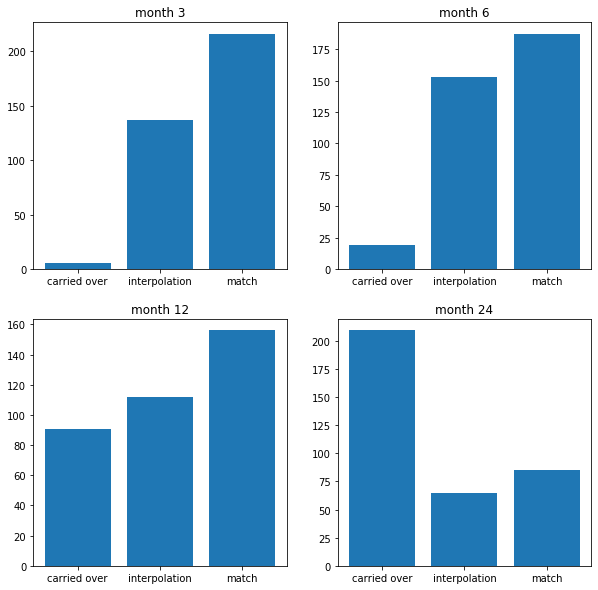

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

### carried over time distribution

Text(0.5, 1.0, 'Time from carry over 6 months')

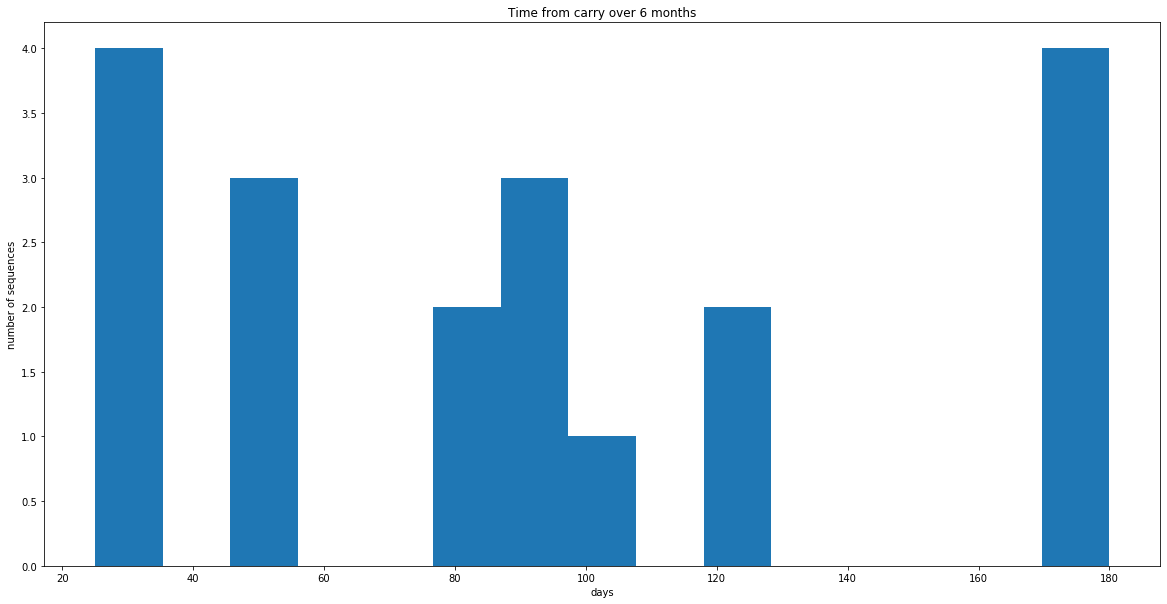

In [8]:
plt.figure(figsize=(20,10))
month_6_carry_over = data_pd.loc[data_pd.insertion_type_6 == "carry_over"]
plt.hist(month_6_carry_over.time_range_6, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 6 months")

Text(0.5, 1.0, 'Time from carry over 12 months')

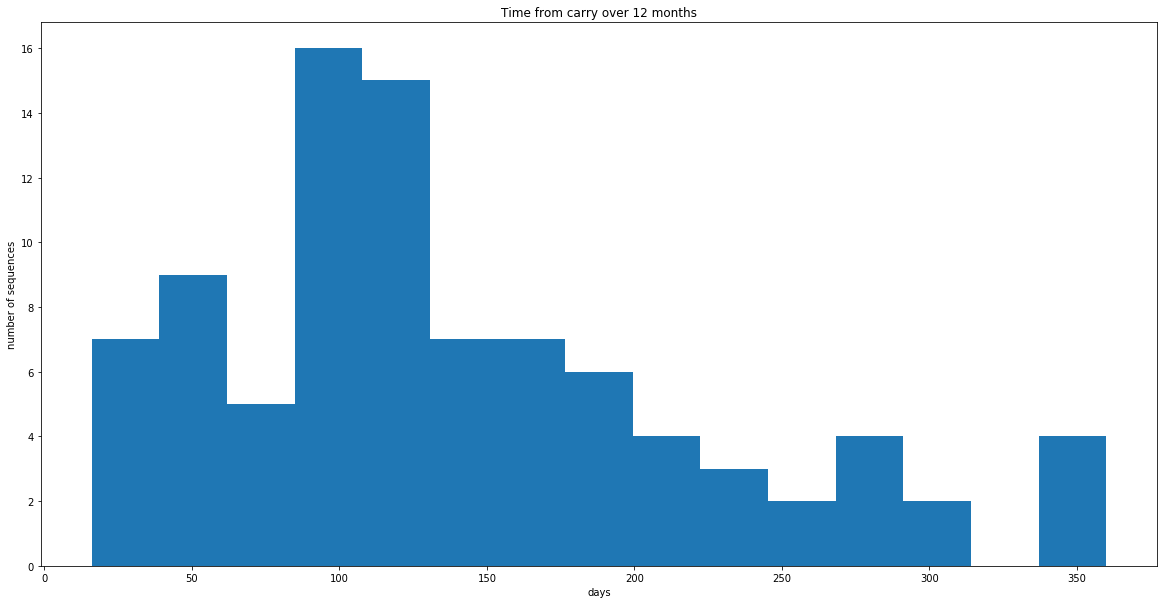

In [9]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12, bins = 15)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over 12 months")


### interpolation over time distribution

Text(0.5, 1.0, 'Time from interpolation 6 months')

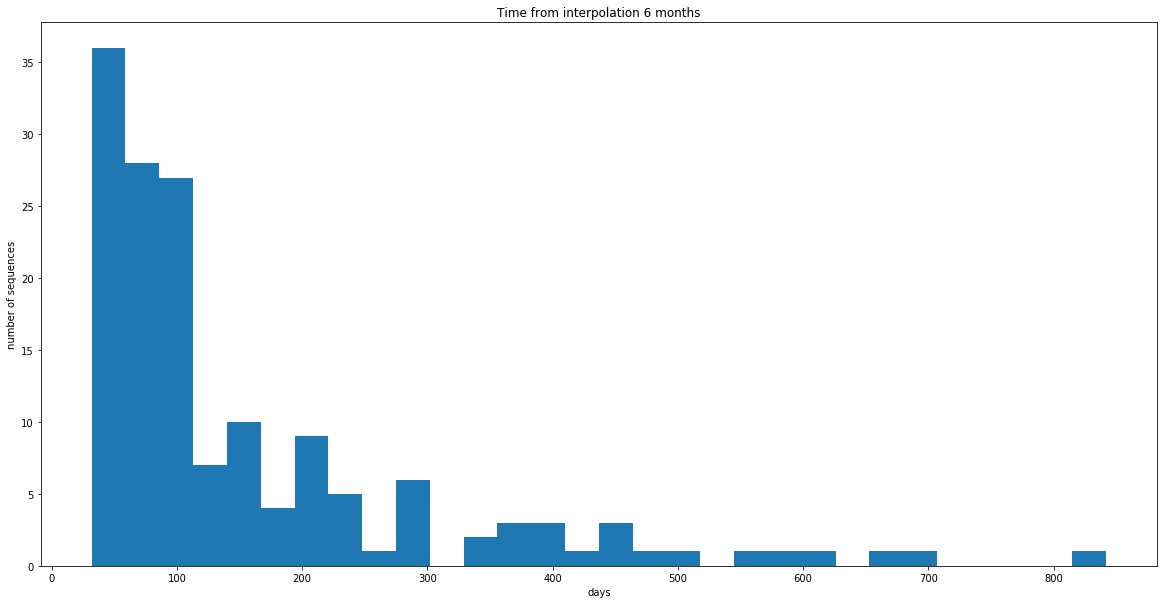

In [10]:
plt.figure(figsize=(20,10))
month_6_interpolation = data_pd.loc[data_pd.insertion_type_6 == "interpolation"]
plt.hist(month_6_interpolation.time_range_6, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 6 months")

Text(0.5, 1.0, 'Time from interpolation 12 months')

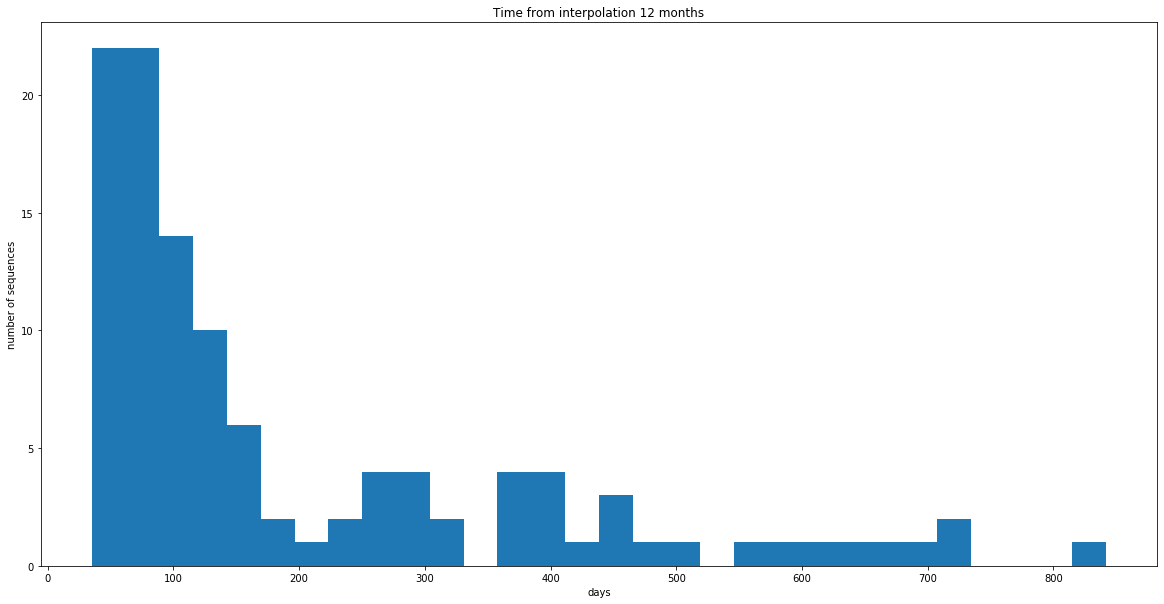

In [11]:
plt.figure(figsize=(20,10))
month_12_interpolation = data_pd.loc[data_pd.insertion_type_12 == "interpolation"]
plt.hist(month_12_interpolation.time_range_12, bins = 30)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from interpolation 12 months")

#### Time until dry

In [12]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))



Number of sequences starting as dry:  3
Number of sequences dry after 3 months:  7
Number of sequences dry after 6 months:  5
Number of sequences dry after 12 months:  6
Number of sequences dry after 24 months:  12


#### Filter data based on time series eclusion criterias

In [13]:
##### carry over above 2 months

In [14]:
columns = ["time_range_6", "time_range_before_6", "time_range_after_6", 
           "time_range_12", "time_range_before_12", "time_range_after_12",
          "insertion_type_6", "insertion_type_12"]

filter_base = data_pd[columns]

# 6 month bools
interp_6 = filter_base.insertion_type_6 == "interpolation" 
carry_over_6 = filter_base.insertion_type_6 == "carry_over" 
match_6 = filter_base.insertion_type_6 == "match" 


interp_12 = filter_base.insertion_type_12 == "interpolation" 
carry_over_12 = filter_base.insertion_type_12 == "carry_over" 
match_12 = filter_base.insertion_type_12 == "match" 

# interpolation time filters
interp_time_before_6 = filter_base.time_range_before_6 < 60
interp_time_after_6 = filter_base.time_range_after_6 < 60

interp_time_before_12 = filter_base.time_range_before_12 < 60
interp_time_after_12 = filter_base.time_range_after_12 < 60

# carry over time filters
carry_over_time_after_6 = filter_base.time_range_6 < 60
carry_over_time_after_12 = filter_base.time_range_12 < 60

In [15]:
# interpolation 6 months
interp_bef = np.logical_and(interp_6.values, interp_time_before_6)
interp_aft = np.logical_and(interp_6.values, interp_time_after_6)

interp_6 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_6 = np.logical_and(carry_over_6.values, carry_over_time_after_6)

insertion_6_ = np.logical_or(carry_over_6, interp_6)
filter_6 = np.logical_or(insertion_6_, match_6)

print("Number of filtered sequences for 6 months are:", sum(filter_6))

Number of filtered sequences for 6 months are: 263


In [16]:
# interpolation 12 months
interp_bef = np.logical_and(interp_12.values, interp_time_before_12)
interp_aft = np.logical_and(interp_12.values, interp_time_after_12)

interp_12 = np.logical_and(interp_bef, interp_aft)

# carry over 6 months
carry_over_12 = np.logical_and(carry_over_12.values, carry_over_time_after_12)

insertion_12_ = np.logical_or(carry_over_12, interp_12)
filter_12 = np.logical_or(insertion_12_, match_12)

print("Number of filtered sequences for 12 months are:", sum(filter_12))

Number of filtered sequences for 12 months are: 214


#### Define VA fate groups

In [17]:
#### Worsened v. Imporoved

In [18]:
data_6 = data_pd.loc[filter_6]
data_12 = data_pd.loc[filter_12]

In [19]:
va_delta_6 = data_6.cur_va_rounded_6 - data_6.cur_va_rounded_1 
va_delta_12 = data_12.cur_va_rounded_12 - data_12.cur_va_rounded_1 

data_6["six_month_recovery"] = va_delta_6 <= 0
data_12["twelwe_month_recovery"] = va_delta_12 <= 0

print("six month recovery: ", sum(data_6["six_month_recovery"]))
print("twelwe month recovery: ", sum(data_12["twelwe_month_recovery"]))

six month recovery:  170
twelwe month recovery:  123


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
### Improved from VI to NVI

In [21]:
vi6_1 = data_6.cur_va_rounded_1 >= 0.4 
nvi_6 = data_6.cur_va_rounded_6 < 0.4

vi12_1 = data_12.cur_va_rounded_1 >= 0.4 
nvi_12 = data_12.cur_va_rounded_12 < 0.4 

data_6["six_month_vi_recovery"] = np.logical_and(vi6_1.values, nvi_6.values)
data_12["twelwe_month_vi_recovery"] = np.logical_and(vi12_1.values, nvi_12.values)

print("six month vi recovery: ", sum(data_6["six_month_vi_recovery"]))
print("twelwe month vi recovery: ", sum(data_12["twelwe_month_vi_recovery"]))

six month vi recovery:  36
twelwe month vi recovery:  31


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
### Improved from LB to NLB

In [23]:
lb6_1 = data_6.cur_va_rounded_1 >= 1.0
nlb_6 = data_6.cur_va_rounded_6 < 1.0 

lb12_1 = data_12.cur_va_rounded_1 >= 1.0
nlb_12 = data_12.cur_va_rounded_12 < 1.0 

data_6["six_month_lb_recoverment"] = np.logical_and(lb6_1.values, nlb_6.values)
data_12["twelwe_month_lb_recoverment"] = np.logical_and(lb12_1.values, nlb_12.values)

print("six month lb recoverment: ", sum(data_6["six_month_lb_recoverment"]))
print("twelwe month lb recoverment: ", sum(data_12["twelwe_month_lb_recoverment"]))


six month lb recoverment:  23
twelwe month lb recoverment:  20


/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### VA outcome distribution plotting

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
sns.set_theme(style="whitegrid")

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Text(0, 0.5, 'Normalized feature distribution')

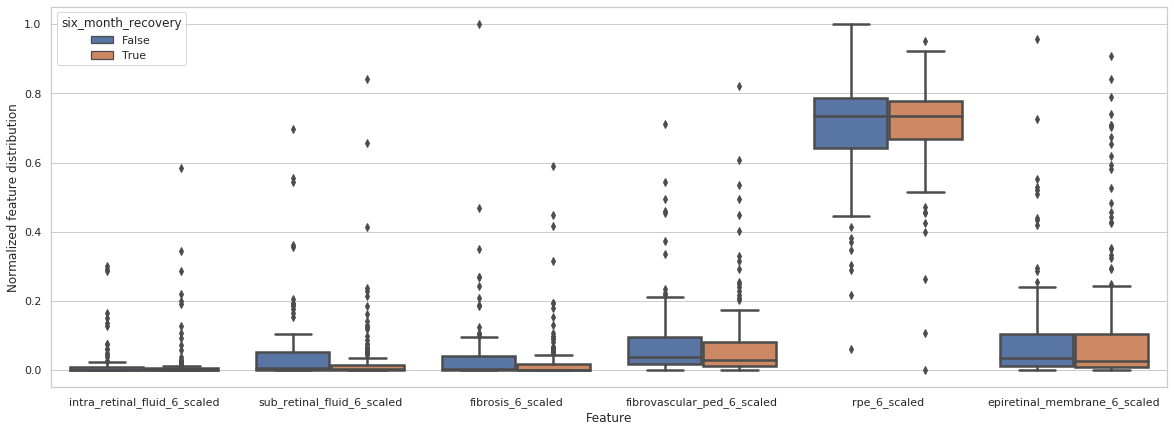

In [25]:
#### six month outcome
value_columns = ["intra_retinal_fluid_6", "sub_retinal_fluid_6", "fibrosis_6", 
          "fibrovascular_ped_6", "rpe_6", "epiretinal_membrane_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_6_scaled", 
                        "sub_retinal_fluid_6_scaled", "fibrosis_6_scaled", 
                        "fibrovascular_ped_6_scaled", "rpe_6_scaled", 
                        "epiretinal_membrane_6_scaled"]


data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns_scaled)

data_6_plotting = data_6_plotting.loc[data_6_plotting.value.values != 1.000]

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5)

plt.xlabel("Feature")
plt.ylabel("Normalized feature distribution")

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

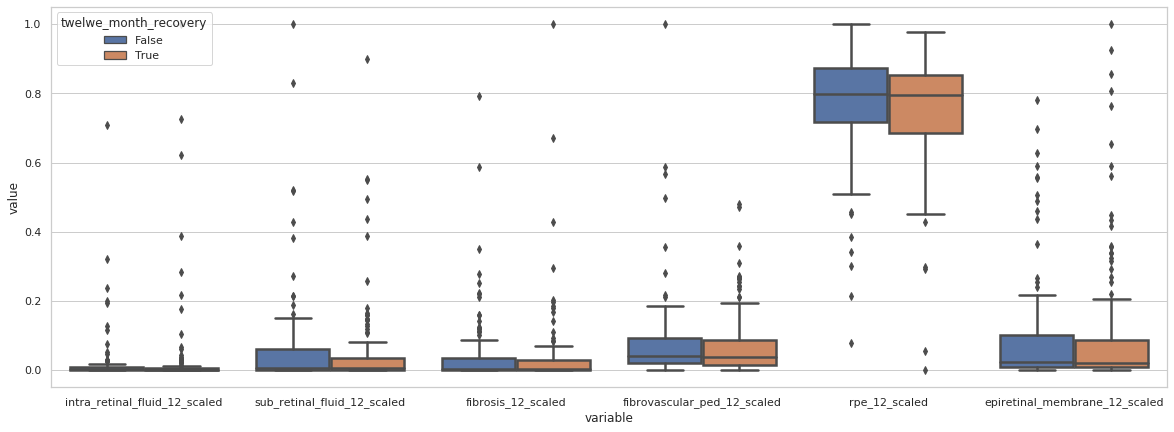

In [26]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_12", "sub_retinal_fluid_12", "fibrosis_12", 
          "fibrovascular_ped_12", "rpe_12", "epiretinal_membrane_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_12_scaled", 
                        "sub_retinal_fluid_12_scaled", "fibrosis_12_scaled", 
                        "fibrovascular_ped_12_scaled", "rpe_12_scaled", 
                        "epiretinal_membrane_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns_scaled)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5)

In [27]:
data_12.columns.values

array(['Unnamed: 0', 'patient_id', 'laterality', 'first_injection_date',
       'Naive', 'sequence', 'Unnamed: 0.1', 'study_date_1',
       'total_fluid_1', 'time_range_1', 'time_range_before_1',
       'time_range_after_1', 'insertion_type_1', 'cur_va_rounded_1',
       'next_va_1', 'intra_retinal_fluid_1', 'sub_retinal_fluid_1',
       'srhm_1', 'fibrovascular_ped_1', 'choroid_1', 'drusen_1', 'rpe_1',
       'epiretinal_membrane_1', 'fibrosis_1', 'study_date_3',
       'total_fluid_3', 'time_range_3', 'time_range_before_3',
       'time_range_after_3', 'insertion_type_3', 'cur_va_rounded_3',
       'next_va_3', 'intra_retinal_fluid_3', 'sub_retinal_fluid_3',
       'srhm_3', 'fibrovascular_ped_3', 'choroid_3', 'drusen_3', 'rpe_3',
       'epiretinal_membrane_3', 'fibrosis_3', 'study_date_6',
       'total_fluid_6', 'time_range_6', 'time_range_before_6',
       'time_range_after_6', 'insertion_type_6', 'cur_va_rounded_6',
       'next_va_6', 'intra_retinal_fluid_6', 'sub_retinal_fluid

#### Plotting delta values

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

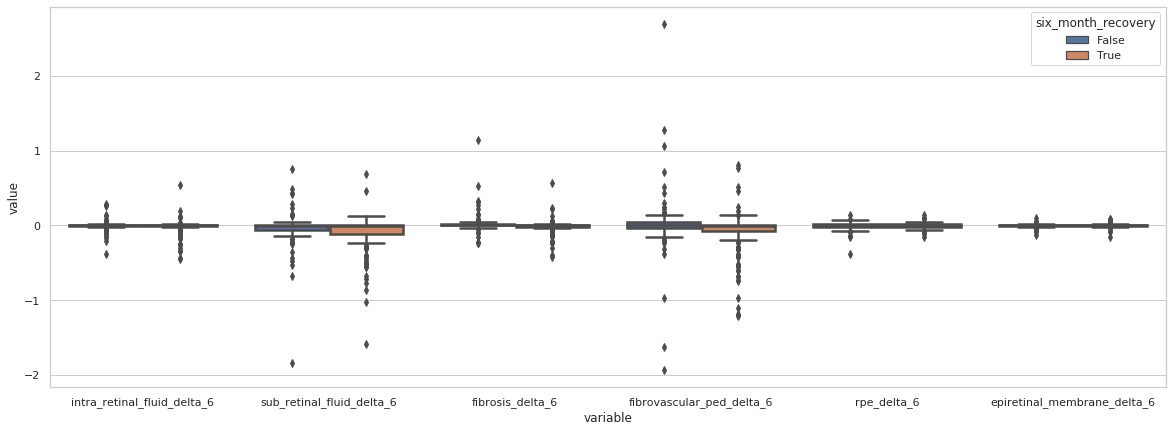

In [28]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_6", "sub_retinal_fluid_delta_6", "fibrosis_delta_6", 
          "fibrovascular_ped_delta_6", "rpe_delta_6", "epiretinal_membrane_delta_6"]

for column in value_columns:
    col_values = data_6[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_6[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_6_scaled", "sub_retinal_fluid_delta_6_scaled", 
                        "fibrosis_delta_6_scaled", "fibrovascular_ped_delta_6_scaled", 
                        "rpe_delta_6_scaled", "epiretinal_membrane_delta_6_scaled"]

data_6_plotting = pd.melt(data_6, id_vars=["six_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="six_month_recovery",
                 data=data_6_plotting, linewidth=2.5)

/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/olle/miniconda3/envs/DeepRT/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

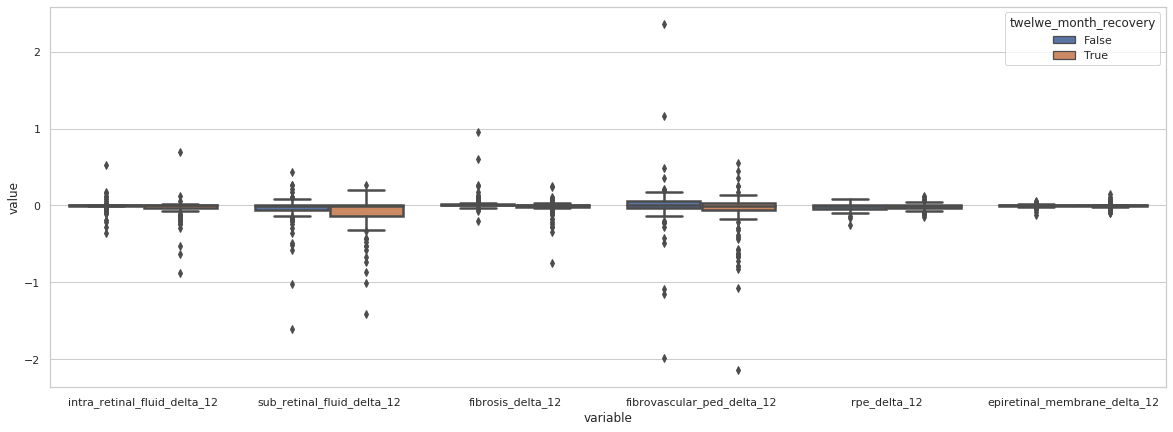

In [29]:
#### 12 month outcome
value_columns = ["intra_retinal_fluid_delta_12", "sub_retinal_fluid_delta_12", "fibrosis_delta_12", 
          "fibrovascular_ped_delta_12", "rpe_delta_12", "epiretinal_membrane_delta_12"]

for column in value_columns:
    col_values = data_12[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(col_values.reshape(-1, 1))
    data_12[column + "_scaled"] = x_scaled
    
    
value_columns_scaled = ["intra_retinal_fluid_delta_12_scaled", "sub_retinal_fluid_delta_12_scaled", 
                        "fibrosis_delta_12_scaled", "fibrovascular_ped_delta_12_scaled", 
                        "rpe_delta_12_scaled", "epiretinal_membrane_delta_12_scaled"]

data_12_plotting = pd.melt(data_12, id_vars=["twelwe_month_recovery"], value_vars=value_columns)

plt.figure(figsize=(20,7))
ax = sns.boxplot(x="variable", y="value", hue="twelwe_month_recovery",
                 data=data_12_plotting, linewidth=2.5)